In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,confusion_matrix, classification_report


current_path = os.getcwd()
root_path = os.path.dirname(current_path)
root_path = os.path.dirname(root_path)

step2_loss_data_path= root_path + '/data/'


In [4]:
df=pd.read_pickle(step2_loss_data_path + '/df_loss_github.pkl')

In [23]:
df.columns

Index(['STATE', 'NUM_UNIT', 'CAUSE_IGN', 'BLDG_ABOVE', 'BLDG_BELOW',
       'TOT_SQ_FT', 'FIRE_ORIG', 'FLAME_SPRD', 'DETECTOR', 'AES_PRES',
       'INCIDENT_KEY', 'response_time', 'last_unit_clear_time',
       'accident_year', 'accident_month', 'accident_day', 'accident_hour',
       'median_income_list', 'median_rent_list', 'Pct_HOU_Occupied_units_list',
       'Pct_HHF_Utility_gas_list', 'Pct_DIS_With_disability_list',
       'Pct_EDU_Bachelor_or_higher_list', 'Pct_HIC_With_coverage_list',
       'Pct_SA_62_and_over_list',
       'Pct_EMP_Pop_16_and_over_in_labor_force_Civilian_labor_force_Employed_list',
       'temp', 'rhum', 'wspd', 'Minority populations', 'Black Alone', 'hum_1',
       'total_loss', 'AREA_ORIG_new', 'ACT_TAK1_new', 'FACT_IGN1_new',
       'HEAT_SOURCE_new', 'FIRST_IGN_new', 'TYPE_MAT_new', 'PROP_USE_new',
       'SUP_FAC_1_new', 'ITEM_SPRD_new', 'MAT_SPRD_new',
       'build_time_1980_to_later_list', 'solar_or_no_fuel', 'coal_or_wood',
       'Risk_Group'],
    

In [34]:
# Assuming df is your DataFrame
object_columns = df.select_dtypes(include=['object']).columns
float_columns = df.select_dtypes(include=['float']).columns


print("Object columns:", object_columns)
print("Float columns:", float_columns)


Object columns: Index(['STATE', 'CAUSE_IGN', 'FLAME_SPRD', 'DETECTOR', 'AES_PRES',
       'INCIDENT_KEY', 'accident_year', 'accident_month', 'accident_day',
       'accident_hour', 'hum_1', 'AREA_ORIG_new', 'ACT_TAK1_new',
       'FACT_IGN1_new', 'HEAT_SOURCE_new', 'FIRST_IGN_new', 'TYPE_MAT_new',
       'PROP_USE_new', 'SUP_FAC_1_new', 'ITEM_SPRD_new', 'MAT_SPRD_new'],
      dtype='object')
Float columns: Index(['NUM_UNIT', 'BLDG_ABOVE', 'BLDG_BELOW', 'TOT_SQ_FT', 'FIRE_ORIG',
       'response_time', 'last_unit_clear_time', 'median_income_list',
       'median_rent_list', 'Pct_HOU_Occupied_units_list',
       'Pct_HHF_Utility_gas_list', 'Pct_DIS_With_disability_list',
       'Pct_EDU_Bachelor_or_higher_list', 'Pct_HIC_With_coverage_list',
       'Pct_SA_62_and_over_list',
       'Pct_EMP_Pop_16_and_over_in_labor_force_Civilian_labor_force_Employed_list',
       'temp', 'rhum', 'wspd', 'Minority populations', 'Black Alone',
       'total_loss', 'build_time_1980_to_later_list', 'solar_o

In [29]:
df.shape

(484964, 46)

In [20]:


# Assuming df is your DataFrame and 'total_loss' is the column with labels
# Create the directory if it doesn't exist
os.makedirs(results_save_path, exist_ok=True)
thresholds = df['total_loss'].quantile([0.4, 0.75])

print(thresholds)
#bins = [-float('inf'), thresholds[0.5], thresholds[0.75], thresholds[0.9], float('inf')]
bins = [-float('inf'), thresholds[0.4], thresholds[0.75], float('inf')]

#labels = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']
labels = ['0', '1', '2']

df['Risk_Group'] = pd.cut(df['total_loss'], bins=bins, labels=labels, include_lowest=True)

X = df.drop(columns=['total_loss','Risk_Group','last_unit_clear_time'])
#X = df.drop(columns=['total_loss','Risk_Group'])
y = df['Risk_Group']
categorical_features = [col for col in X.columns if X[col].dtype == 'object']


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2042)

# Create Pool objects for CatBoost
train_data = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_data = Pool(data=X_test, label=y_test, cat_features=categorical_features)

# Initialize and train the CatBoost model
model = CatBoostClassifier(iterations=1000,
                           depth=5,
                           learning_rate=0.1,
                           loss_function='MultiClass',
                           task_type='GPU',
                           random_state=2042)
model.fit(train_data, verbose=100)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

# Create a DataFrame with actual and predicted values
# results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the first few rows of the DataFrame


0.40    10661.157025
0.75    67755.140187
Name: total_loss, dtype: float64
0:	learn: 1.0776130	total: 26.1ms	remaining: 26.1s
100:	learn: 0.9179451	total: 1.36s	remaining: 12.1s
200:	learn: 0.9056107	total: 2.54s	remaining: 10.1s
300:	learn: 0.8992531	total: 3.7s	remaining: 8.59s
400:	learn: 0.8949550	total: 4.84s	remaining: 7.24s
500:	learn: 0.8917175	total: 5.99s	remaining: 5.97s
600:	learn: 0.8889669	total: 7.14s	remaining: 4.74s
700:	learn: 0.8865812	total: 8.29s	remaining: 3.54s
800:	learn: 0.8842830	total: 11.2s	remaining: 2.79s
900:	learn: 0.8820950	total: 13s	remaining: 1.43s
999:	learn: 0.8801131	total: 14.1s	remaining: 0us
Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.61      0.71      0.65     58408
           1       0.49      0.44      0.46     50674
           2       0.57      0.51      0.54     36408

    accuracy                           0.56    145490
   macro avg       0.56      0.55      0.55    145490
weighted avg      

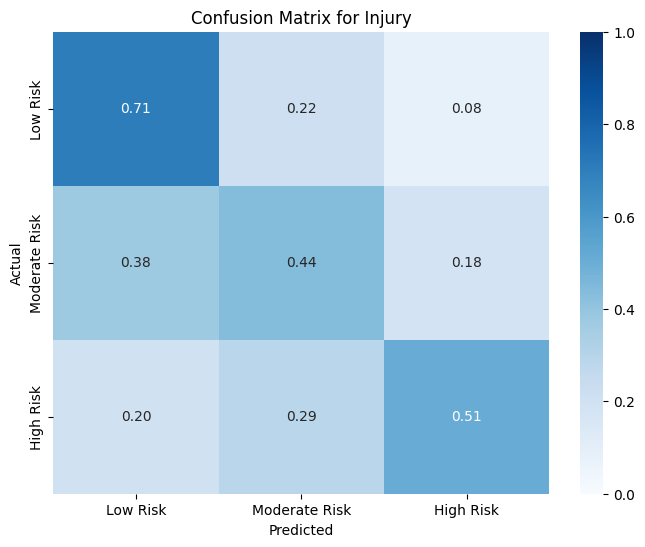

In [22]:
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to 0-1 scale
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define the new labels
labels = ['Low Risk', 'Moderate Risk', 'High Risk']

# Plot the confusion matrix with a normalized color bar (0-1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Injury')
#plt.colorbar(label='Proportion')
plt.show()
